`Last update at 2021-08-11`

## Outline

```
    3) Creating BGC fingerprints and running KNN:
    3.1) Loading ENA_dict;
    3.2) Running BiG-SCAPE in a external server; (estimated runtime of 3h)
    3.3) Concatenating BiG-SCAPE results;
    3.4) Processing BiG-SCAPE data;
    3.5) Renaming BGCs in dataframe and dictionary;
    3.6) Creating affinity dataframe;
    3.7) Select ground truth data found in the gene network;
    3.8) Filtering affinity dataframe to create traning and testing dataframes;
    3.9) Processing KNN;
    3.10) Running cross-validation;
    3.11) Plotting fingerprints.
    
```

In [1]:
import pandas as pd
import time
import glob
import numpy as np
import csv
import subprocess
import glob
import os
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.model_selection import cross_val_score

# 3. Creating BGC fingerprints and running KNN

## 3.1. Loading ENA_dict

In [2]:
ena_df = pd.read_csv('./temp_files/ena_dict-round3-210315.csv',sep=',',names=['ERR_code','ERXS_code'])

ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))

## 3.2. Running BiG-SCAPE in a external server

```
python /home/gerwick-lab/Desktop/bigscape/BiG-SCAPE/bigscape.py \
-i /home/gerwick-lab/Desktop/bigscape/podp_antiSMASH/ \
-o /home/gerwick-lab/Desktop/bigscape/bigscape_outputs_210504/ \
-c 12 --include_singletons --pfam_dir /home/gerwick-lab/Desktop/bigscape --mibig
```

## 3.3. Concatenating BiG-SCAPE results

In [3]:
# %%bash

# cd ./bigscape_outputs_210427/

# rm ./bigscape_all_c030.txt
# find ./network_files/2021-04-27_11-36-19_hybrids_glocal/ -type f -name *_c0.30.network | cat > ./network_files.txt
# while read line; do cat $line >> ./pre_bigscape_all_c030.txt; done < ./network_files.txt
# awk '/Clustername/&&c++>0 {next} 1' ./pre_bigscape_all_c030.txt >> ./bigscape_all_c030.txt

For stats on the annotated metagenomes, see notebook 4 - GCF metadata

## 3.4. Processing BiG-SCAPE data

In [4]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = get_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

In [5]:
input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/bigscape_outputs_210427/bigscape_all_c030.txt"

bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)

# to convert from distance to similarity:
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,c00601_NODE_60...region001,c01555_NODE_15...region001,0.708449,0.501900,0.600000,0.708449,0.5,0.500000,0.083102,4,1,NRPS - NRPS-like,NaN
1,ADZB01000031.1.region001,GL383169.1.region001,0.945554,0.894073,1.000000,0.945554,1.0,0.031329,0.071784,9,3,NRPS - NRPS,NRPS
2,ADZL01000027.1.region001,GL383245.1.region001,0.966176,0.933495,1.000000,0.966176,1.0,0.030806,0.039861,24,3,NRPS - NRPS,NRPS
3,BGC0001130.1,NJAI01000004.1.region001,0.760534,0.578411,0.842105,0.760534,0.8,0.259097,0.232689,29,21,hglE-KS.T1PKS.PUFA.NRPS - nrps.t1pks.hglks,NaN
4,ADYN01000035.1.region001,GL383759.1.region002,0.980572,0.961522,1.000000,0.980572,1.0,0.024890,0.010779,19,3,NRPS - NRPS,NRPS


In [6]:
len(bigscape_dict)

997

## 3.5. Renaming BGCs in dataframe and dictionary

In [7]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file and '._' not in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Volumes/TFL190831/ming_output/antismash/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

len(gbk_list),len(new_name_list)

(13848, 13848)

In [8]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    if 'BGC' in bigscape_df['Clustername_1'].loc[i]:
        new_col1.append(bigscape_df['Clustername_1'].loc[i])
    else:
        new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    if 'BGC' in bigscape_df['Clustername_2'].loc[i]:
        new_col2.append(bigscape_df['Clustername_2'].loc[i])
    else:
        new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,ERR3946801_contigs.region008,ERR3941251_contigs.region005,0.708449,0.501900,0.600000,0.708449,0.5,0.500000,0.083102,4,1,NRPS - NRPS-like,NaN
1,2531839226.region002,GCA_000144085.region001,0.945554,0.894073,1.000000,0.945554,1.0,0.031329,0.071784,9,3,NRPS - NRPS,NRPS
2,2531839427.region002,GCA_000144125.region001,0.966176,0.933495,1.000000,0.966176,1.0,0.030806,0.039861,24,3,NRPS - NRPS,NRPS
3,BGC0001130.1,NJAI00000000.region015,0.760534,0.578411,0.842105,0.760534,0.8,0.259097,0.232689,29,21,hglE-KS.T1PKS.PUFA.NRPS - nrps.t1pks.hglks,NaN
4,2537561582.region001,GCA_000144735.region003,0.980572,0.961522,1.000000,0.980572,1.0,0.024890,0.010779,19,3,NRPS - NRPS,NRPS


In [9]:
bigscape_dict2 = defaultdict(list)

for key in bigscape_dict:
    for value in bigscape_dict[key]:
        if 'BGC' in value:
            bigscape_dict2[key].append(value)
        else:
            if 'ERR' in name_dict[value]:
                new_ERR_name = name_dict[value].split('_')[0] + '.' + name_dict[value].split('.')[1]
                bigscape_dict2[key].append(new_ERR_name)
            else:
                bigscape_dict2[key].append(name_dict[value])
        
len(bigscape_dict2)

997

In [10]:
# w = csv.writer(open("./outputs/names_dict-round4-TFL210723.txt", "w"))

# for key, val in name_dict.items():
#     w.writerow([key, val])

## 3.6. Creating affinity dataframe

In [11]:
def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split(".")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    return training_df,row_names

In [12]:
bgcs_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split(".")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)

affinity_df.shape

(5681, 1184)

In [13]:
!ls -d /Volumes/TFL190831/ming_output/antismash/*/ | wc -l

    1766


In [14]:
!ls -d /Volumes/TFL190831/ming_output/antismash/ER*/ | wc -l

    1034


In [15]:
affinity_df[:5]

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [16]:
new_affinity_names = []

for item in list(affinity_df.columns):
    if '_contigs' in item:
        new_affinity_names.append(item.split('_')[0])
    else:
        new_affinity_names.append(item)
        
affinity_df.columns = new_affinity_names

In [17]:
affinity_df[:5]

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [18]:
affinity_df.shape

(5681, 1184)

In [19]:
# affinity_df.to_csv("./outputs/affinity_df-round4-TFL210427.txt")
# pickle.dump( affinity_bgcs, open( "./outputs/affinity_bgcs-round4-TFL210427.txt", "wb" ) )

## 3.7 Select ground truth data found in the gene network

In [20]:
mibig_gnps_dict = {}
mibig_gnps_df = pd.read_csv('/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/inputs/matched_mibig_gnps_update.tsv',sep='\t')
mibig_gnps_dict = dict(zip(mibig_gnps_df['# mgf_spectrum_id'],mibig_gnps_df['mibig_id']))

In [21]:
testing_indexes,select_list,affinity_gcfs = [],[],[]

test_glob = glob.glob("./inputs/selected_mgf_round3/*")

for item in test_glob:
    testing_indexes.append(os.path.basename(item).split('.')[0])

for index,ccms_id in enumerate(testing_indexes):
    if ccms_id in mibig_gnps_dict.keys():
        for i,bgc in enumerate(affinity_bgcs):
            if mibig_gnps_dict[ccms_id] in bgc:
                select_list.append(ccms_id)
                affinity_gcfs.append(affinity_df.label[i])
                print(ccms_id,affinity_df.label[i])

CCMSLIB00000567505 GCF329
CCMSLIB00000566828 GCF205
CCMSLIB00004679300 GCF450
CCMSLIB00004681487 GCF476
CCMSLIB00005436037 GCF62
CCMSLIB00000566784 GCF205
CCMSLIB00000568582 GCF438
CCMSLIB00000574381 GCF205
CCMSLIB00004681486 GCF476
CCMSLIB00004692003 GCF276
CCMSLIB00004684885 GCF276
CCMSLIB00000572123 GCF329
CCMSLIB00000574383 GCF205
CCMSLIB00005435930 GCF2
CCMSLIB00000568813 GCF438
CCMSLIB00000223877 GCF347
CCMSLIB00004684884 GCF276
CCMSLIB00000579271 GCF14
CCMSLIB00004692006 GCF276
CCMSLIB00004679299 GCF450
CCMSLIB00004681481 GCF476
CCMSLIB00000566543 GCF205
CCMSLIB00005435934 GCF3
CCMSLIB00004679298 GCF450
CCMSLIB00004692007 GCF276
CCMSLIB00004684883 GCF276
CCMSLIB00004692011 GCF276
CCMSLIB00004692005 GCF276
CCMSLIB00004681482 GCF62
CCMSLIB00000839195 GCF62
CCMSLIB00000568790 GCF438
CCMSLIB00000568829 GCF438
CCMSLIB00000220439 GCF329
CCMSLIB00004692004 GCF276
CCMSLIB00004692010 GCF276
CCMSLIB00004684882 GCF276
CCMSLIB00000424891 GCF461
CCMSLIB00000219744 GCF329
CCMSLIB00000220304 G

In [22]:
len(np.unique(affinity_gcfs))

22

In [23]:
# !mkdir ./selected_mgf_round4/

In [24]:
from pyteomics import mgf, auxiliary

with mgf.MGF('inputs/matched_mibig_gnps_update.mgf') as reader:
    for spectrum in reader:
        if spectrum['params']['spectrumid'] in select_list:
            individual_spec = []
            individual_spec.append(spectrum)
            output_file = '/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf_round4/%s.mgf'%(spectrum['params']['spectrumid'])
#             mgf.write(spectra=individual_spec, header='', output=output_file)

In [25]:
!ls /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf_round4/ | wc -l

ls: /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf_round4/: No such file or directory
       0


In [26]:
### code to make sure that all MS/MS spectra were copied to the folder
selected_indexes = []

selected_glob = glob.glob("./selected_mgf_round4/*")

for item in selected_glob:
    selected_indexes.append(os.path.basename(item).split('.')[0])

for index,ccms_id in enumerate(select_list):
    if ccms_id not in selected_indexes:
        print(ccms_id,mibig_gnps_dict[ccms_id])

CCMSLIB00000567505 BGC0000713
CCMSLIB00000566828 BGC0001667
CCMSLIB00004679300 BGC0000399
CCMSLIB00004681487 BGC0001088
CCMSLIB00005436037 BGC0000936
CCMSLIB00000566784 BGC0001705
CCMSLIB00000568582 BGC0000114
CCMSLIB00000574381 BGC0001705
CCMSLIB00004681486 BGC0001088
CCMSLIB00004692003 BGC0000262
CCMSLIB00004684885 BGC0000262
CCMSLIB00000572123 BGC0000713
CCMSLIB00000574383 BGC0001705
CCMSLIB00005435930 BGC0000319
CCMSLIB00000568813 BGC0000114
CCMSLIB00000223877 BGC0001830
CCMSLIB00004684884 BGC0000262
CCMSLIB00000579271 BGC0001792
CCMSLIB00004692006 BGC0000262
CCMSLIB00004679299 BGC0000398
CCMSLIB00004681481 BGC0001088
CCMSLIB00000566543 BGC0001705
CCMSLIB00005435934 BGC0000373
CCMSLIB00004679298 BGC0000399
CCMSLIB00004692007 BGC0000262
CCMSLIB00004684883 BGC0000262
CCMSLIB00004692011 BGC0000262
CCMSLIB00004692005 BGC0000262
CCMSLIB00004681482 BGC0000936
CCMSLIB00000839195 BGC0000936
CCMSLIB00000568790 BGC0000114
CCMSLIB00000568829 BGC0000114
CCMSLIB00000220439 BGC0000713
CCMSLIB000

In [27]:
### merging NPLinker/PoDP mgf files to the Gerwick mgf
# !mv /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf_round4/* /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/NPOmix_mgf_spectra/
# !rm -r /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf_round4/

## 3.8. Filtering affinity dataframe to create traning and testing dataframes

In [28]:
### first run the notebook 2 to process ispec_mat (by Ricardo Silva)

ispec_mat = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/outputs/mass-affinity_df-NPOmix1.0-TFL210811.txt",sep="\t")

ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,GCA_010692445,GCA_010692465,GCA_010692525,GCA_010692535,GCA_010692555,GCA_010692575,GCA_010692585,GCA_010692635,GCA_010692645,GCA_010692685
CCMSLIB00000001675,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00005720216,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.303654,0.000000,0.0,0.417548,0.000000,0.0,0.0,0.190368,0.000000,0.192304
CCMSLIB00000006873,0.0,0.0,0.0,0.0,0.0,0.016627,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000070259,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.906417,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000579285,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001650,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.093959,0.0,0.0,0.000000,0.000000,0.014037
CCMSLIB00000478602,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001644,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [29]:
new_cols_ispec = []

for item in ispec_mat.columns:
    if 'ERS' in item or 'ERX' in item:
        new_cols_ispec.append(ena_dict[item])
    else:
        new_cols_ispec.append(item)
        
ispec_mat.columns = new_cols_ispec

ispec_mat

,ERR3941051,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,GCA_010692445,GCA_010692465,GCA_010692525,GCA_010692535,GCA_010692555,GCA_010692575,GCA_010692585,GCA_010692635,GCA_010692645,GCA_010692685
CCMSLIB00000001675,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00005720216,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.303654,0.000000,0.0,0.417548,0.000000,0.0,0.0,0.190368,0.000000,0.192304
CCMSLIB00000006873,0.0,0.0,0.0,0.0,0.0,0.016627,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000070259,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.906417,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000579285,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001650,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.093959,0.0,0.0,0.000000,0.000000,0.014037
CCMSLIB00000478602,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001644,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [30]:
networked_cols = []

for item in ispec_mat.columns:
    if item in affinity_df.columns:
        networked_cols.append(item)
        
len(networked_cols)

1040

In [31]:
### PS: for some reason the processed affinity_df has less values than the saved one, therefore we will use the later

affinity_df = pd.read_csv("./outputs/affinity_df-round4-TFL210427.txt",index_col=0)

affinity_df.shape

(5681, 1184)

In [32]:
training_df = affinity_df[networked_cols]
label_col = affinity_df['label']
training_df = training_df[(training_df.T != 0).any()]

filt_label_col = []
for n,item in enumerate(label_col):
    if n in training_df.index:
        filt_label_col.append(item)


training_df['label'] = filt_label_col
training_df = training_df.sort_index(axis=1)
training_df = training_df.reset_index(drop=True)

training_df

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF995
4908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF996
4909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF996
4910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF997


In [33]:
training_df[training_df['2515154094'] != 0]

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1,label
1335,0.755078,0.0,0.996497,0.0,0.0,1.000000,0.0,0.949441,0.986978,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF128
1336,0.742796,0.0,0.949923,0.0,0.0,0.949441,0.0,1.000000,0.947058,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF128
1337,1.000000,0.0,0.755700,0.0,0.0,0.755078,0.0,0.742796,0.743652,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF128
1339,0.779263,0.0,0.818570,0.0,0.0,0.817659,0.0,0.831320,0.824704,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF128
1340,0.755700,0.0,1.000000,0.0,0.0,0.996497,0.0,0.949923,0.986907,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0.721622,0.0,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF369
2524,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF373
2525,0.989703,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF373
2526,0.748702,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF374


In [34]:
testing_df = ispec_mat[networked_cols]
testing_df = testing_df.sort_index(axis=1) ### comment this line out for random result
testing_df = testing_df[testing_df > 0.7].replace(np.nan,0)
testing_df = testing_df[(testing_df.T != 0).any()]

testing_df

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM6v1,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1
CCMSLIB00000070259,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00000070265,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004679300,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004681487,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00005436037,0.0,0.850631,0.846193,0.0,0.0,0.0,0.0,0.861537,0.0,0.0,...,0.810669,0.798644,0.805277,0.806636,0.843194,0.793839,0.830068,0.823502,0.794014,0.811453
CCMSLIB00004681486,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00005464638,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00000070258,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004692003,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00000070266,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
ispec_mat.shape,training_df.shape,testing_df.shape

((486, 1571), (4912, 1041), (49, 1040))

`Only use the next two cells below for presence/absence comparision`

In [36]:
### only run once

# family_counts = []

# for i,r in training_df.drop('label',axis=1).iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# training_df = pd.DataFrame(family_counts,columns=networked_cols,index=training_df.index)

# training_df['label'] = filt_label_col

# training_df[:5]

In [37]:
### only run once

# family_counts = []

# for i,r in testing_df.iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# testing_df = pd.DataFrame(family_counts,columns=networked_cols,index=testing_df.index)

# testing_df[:5]

In [38]:
# training_df.to_csv('./outputs/training_df-round4-TFL210504.tsv',sep='\t')
# testing_df.to_csv('./outputs/testing_df-round4-TFL210504.tsv',sep='\t')

## 3.9. Processing KNN

In [39]:
X_div = training_df.drop("label", axis=1)
X_div.shape

(4912, 1040)

In [40]:
y_div = training_df["label"]
y_div.shape

(4912,)

In [41]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_div,y_div)

distances, indices = nbrs.kneighbors(testing_df)

In [42]:
y_div = y_div.reset_index(drop=True)

neighbors_array = []

for item in indices:
    candidate_list = []
    for i in range(3):
        candidate_list.append(y_div[item[i]])
    neighbors_array.append(candidate_list)

neighbors_array = np.asarray(neighbors_array)
        
neighbors_array

array([['GCF601', 'GCF606', 'GCF596'],
       ['GCF627', 'GCF612', 'GCF627'],
       ['GCF465', 'GCF445', 'GCF450'],
       ['GCF476', 'GCF180', 'GCF476'],
       ['GCF102', 'GCF102', 'GCF102'],
       ['GCF476', 'GCF180', 'GCF476'],
       ['GCF638', 'GCF579', 'GCF637'],
       ['GCF601', 'GCF606', 'GCF596'],
       ['GCF925', 'GCF992', 'GCF992'],
       ['GCF627', 'GCF612', 'GCF627'],
       ['GCF465', 'GCF445', 'GCF450'],
       ['GCF476', 'GCF180', 'GCF476'],
       ['GCF471', 'GCF498', 'GCF471'],
       ['GCF465', 'GCF445', 'GCF439'],
       ['GCF70', 'GCF674', 'GCF676'],
       ['GCF95', 'GCF105', 'GCF105'],
       ['GCF579', 'GCF578', 'GCF581'],
       ['GCF636', 'GCF517', 'GCF628'],
       ['GCF149', 'GCF149', 'GCF22'],
       ['GCF446', 'GCF446', 'GCF446'],
       ['GCF578', 'GCF612', 'GCF627'],
       ['GCF122', 'GCF115', 'GCF112'],
       ['GCF471', 'GCF498', 'GCF471'],
       ['GCF819', 'GCF837', 'GCF812'],
       ['GCF553', 'GCF626', 'GCF626'],
       ['GCF640', 'GCF633', 

In [43]:
len(testing_df),len(neighbors_array)

(49, 49)

In [44]:
correct_count = 0
incorrect_count = 0
ccms_id_label_dict = {}

for index,ccms_id in enumerate(testing_df.index):
    if ccms_id in mibig_gnps_dict:
        for i,bgc in enumerate(affinity_bgcs):
            if mibig_gnps_dict[ccms_id] in bgc:
                print(ccms_id,affinity_df.label[i],neighbors_array[index])
                if affinity_df.label[i] in neighbors_array[index]:
                    print("Correct")
                    correct_count += 1
                    ccms_id_label_dict[ccms_id] = affinity_df.label[i]
                else:
                    print("Incorrect")
                    incorrect_count += 1
                    ccms_id_label_dict[ccms_id] = affinity_df.label[i]
                    
total_count = incorrect_count + correct_count

print('Precision = %s/%s = %s'%(correct_count,total_count,(correct_count/total_count)))

CCMSLIB00004679300 GCF450 ['GCF465' 'GCF445' 'GCF450']
Correct
CCMSLIB00004681487 GCF476 ['GCF476' 'GCF180' 'GCF476']
Correct
CCMSLIB00005436037 GCF62 ['GCF102' 'GCF102' 'GCF102']
Incorrect
CCMSLIB00004681486 GCF476 ['GCF476' 'GCF180' 'GCF476']
Correct
CCMSLIB00004692003 GCF276 ['GCF925' 'GCF992' 'GCF992']
Incorrect
CCMSLIB00004679299 GCF450 ['GCF465' 'GCF445' 'GCF450']
Correct
CCMSLIB00004681481 GCF476 ['GCF476' 'GCF180' 'GCF476']
Correct
CCMSLIB00000001706 GCF471 ['GCF471' 'GCF498' 'GCF471']
Correct
CCMSLIB00004679298 GCF450 ['GCF465' 'GCF445' 'GCF439']
Incorrect
CCMSLIB00004681482 GCF62 ['GCF70' 'GCF674' 'GCF676']
Incorrect
CCMSLIB00000839195 GCF62 ['GCF95' 'GCF105' 'GCF105']
Incorrect
CCMSLIB00004685866 GCF445 ['GCF149' 'GCF149' 'GCF22']
Incorrect
CCMSLIB00000479759 GCF320 ['GCF122' 'GCF115' 'GCF112']
Incorrect
CCMSLIB00005724004 GCF498 ['GCF471' 'GCF498' 'GCF471']
Correct
CCMSLIB00004693587 GCF445 ['GCF553' 'GCF626' 'GCF626']
Incorrect
CCMSLIB00000840594 GCF488 ['GCF740' 'GCF740' 

In [48]:
from sklearn.metrics import jaccard_score

def get_binary(fingerprint):
    new_row = []
    for index,item in enumerate(fingerprint):
        if item != 0:
            new_row.append(1)
        else:
            new_row.append(0)
    fingerprint = new_row
    return fingerprint

jaccard_list = []

for i,ccms_id in enumerate(testing_df.index):
    jaccard_scores = []
    for j in range(0,len(neighbors_array[i])):
        query_bgc = neighbors_array[i][j]
        bgc_fp = training_df[training_df['label'] == query_bgc].iloc[0]
        bgc_fp = bgc_fp.drop("label")
        ms_fp = testing_df.loc[ccms_id]
        bgc_binary = get_binary(bgc_fp)
        ms_binary = get_binary(ms_fp)
        jaccard_scores.append(jaccard_score(bgc_binary,ms_binary))
    max_jaccard = max(jaccard_scores)
    if max_jaccard > 0.9:
        if ccms_id in ccms_id_label_dict:
            if ccms_id_label_dict[ccms_id] in neighbors_array[i]:
                print(ccms_id,ccms_id_label_dict[ccms_id],neighbors_array[i],max_jaccard,'correct')
            else:
                print(ccms_id,ccms_id_label_dict[ccms_id],neighbors_array[i],max_jaccard,'incorrect')
        else:
            print(ccms_id,'orphan',neighbors_array[i],max_jaccard,'incorrect')
        jaccard_list.append(ccms_id)

CCMSLIB00004679300 GCF450 ['GCF465' 'GCF445' 'GCF450'] 1.0 correct
CCMSLIB00004681487 GCF476 ['GCF476' 'GCF180' 'GCF476'] 1.0 correct
CCMSLIB00004681486 GCF476 ['GCF476' 'GCF180' 'GCF476'] 1.0 correct
CCMSLIB00004679299 GCF450 ['GCF465' 'GCF445' 'GCF450'] 1.0 correct
CCMSLIB00004681481 GCF476 ['GCF476' 'GCF180' 'GCF476'] 1.0 correct
CCMSLIB00000001706 GCF471 ['GCF471' 'GCF498' 'GCF471'] 1.0 correct
CCMSLIB00004679298 GCF450 ['GCF465' 'GCF445' 'GCF439'] 1.0 incorrect
CCMSLIB00000479759 GCF320 ['GCF122' 'GCF115' 'GCF112'] 1.0 incorrect
CCMSLIB00005724004 GCF498 ['GCF471' 'GCF498' 'GCF471'] 1.0 correct
CCMSLIB00000840594 GCF488 ['GCF740' 'GCF740' 'GCF739'] 1.0 incorrect
CCMSLIB00000001553 orphan ['GCF471' 'GCF498' 'GCF471'] 1.0 incorrect
CCMSLIB00000001751 orphan ['GCF471' 'GCF498' 'GCF471'] 1.0 incorrect
CCMSLIB00000001708 GCF471 ['GCF471' 'GCF498' 'GCF471'] 1.0 correct
CCMSLIB00004681475 GCF476 ['GCF476' 'GCF180' 'GCF476'] 1.0 correct
CCMSLIB00000579285 GCF476 ['GCF476' 'GCF180' 'GCF476

In [49]:
10/15*100

66.66666666666666

In [50]:
count = 0

for item in affinity_bgcs:
    if 'BGC' in item:
        count += 1
        
len(affinity_bgcs)-count,count,len(affinity_bgcs)

(5421, 260, 5681)

In [51]:
c = 0

for item in training_df.columns:
    if 'ERR' in item:
        c += 1
        
c,len(training_df.columns)-c,len(training_df.columns)

(680, 361, 1041)

In [52]:
final_testing = testing_df.loc[jaccard_list]

final_testing

,2515154094,2515154124,2515154177,2515154206,2516143022,2516493032,2517434008,2517572145,2517572157,2517572165,...,SspCM6v1,SspCM7v1,SspOBRC6v1,SspSR1v1,Stre_inte_F0413_V1,Stre_para_CC87K_V1,Stre_sang_CC94A_V1,Trep_dent_ASLM_V1,Trep_dent_US-Trep_V1,VspACP1v1
CCMSLIB00004679300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004679299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000001706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004679298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000479759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00005724004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000840594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# final_testing.to_csv('./outputs/testing_df-NPOmixv1.0-TFL210811.tsv',sep='\t')

## 3.10. Running cross-validation

In [54]:
knn_cv = KNeighborsClassifier(n_neighbors=5)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_div, y_div, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[0.56052899 0.5768057  0.58350305 0.57739308 0.54684318]
cv_scores mean:0.5690147994521945


## 3.11. Plotting fingerprints

In [55]:
gcf_query = 'GCF450'

In [56]:
bigscape_dict2[gcf_query]

['BGC0000399.1', 'BGC0000398.1', 'GCA_000012265.region004']

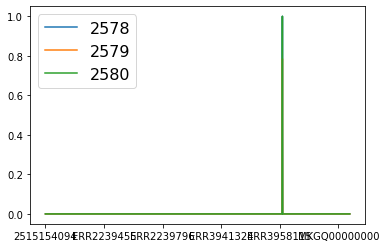

In [57]:
gcf_subset1 = training_df[training_df['label'] == gcf_query].T
gcf_subset1 = gcf_subset1.drop('label')

gcf_subset1.plot().legend(loc=2, prop={'size': 16})

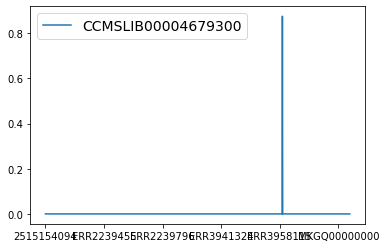

In [58]:
mf_subset1 = testing_df.loc['CCMSLIB00004679300'].T

mf_subset1.plot().legend(loc=2, prop={'size': 14})

In [59]:
mibig_gnps_df[mibig_gnps_df['# mgf_spectrum_id'] == 'CCMSLIB00004679300']

,# mgf_spectrum_id,mgf_inchikey,mgf_smiles,mibig_id,mibig_name,mibig_inchi,mibig_smiles
223,CCMSLIB00004679300,STDTUHSFISWYFO-UHFFFAOYSA-N,CCCCCCCCCC(O)CC(NC(C(NC(C(NC1C(C)OC(C(C(C)C)NC...,BGC0000399,Orfamide C,STDTUHSFISWYFO-UHFFFAOYSA-N,CCCCCCCCCC(O)CC(=O)NC(CC(C)C)C(=O)NC(CCC(O)=O)...
